## Analyzing synthesized population
Now that the functions are all in place for generating the data, lets synthesize a population to work with and see if the MCMC can reconstruct it. Before we try any sort of way to remove the exponential part and just work with the gaussian by setting `f=1` in the mass generator

First step: generate the data we'll use:

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *
from astropy.cosmology import units as cu

sns.set_context('notebook')
sns.set_palette('colorblind')

import matplotlib
matplotlib.rcParams['font.family'] = 'serif' # so these plots can go into thesis


%matplotlib inline

In [2]:
ms = generate_masses(f=1)
d_Ls = generate_dLs()
z_s = dLs_to_zs(d_Ls)

35.05737574699451 2.362781215377663 117.92483639942117
(10000,)


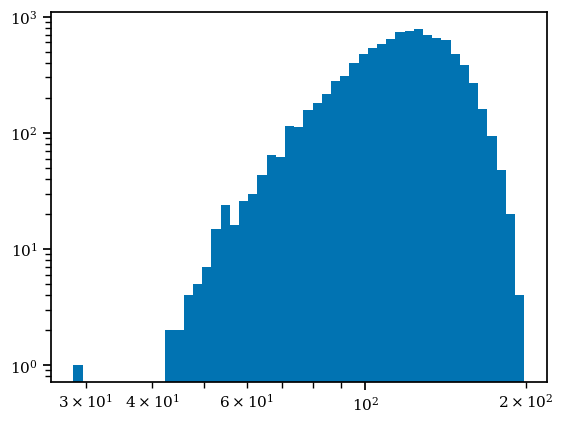

In [3]:
m_det = ms*(1+z_s)
print(np.mean(ms), np.mean(z_s), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

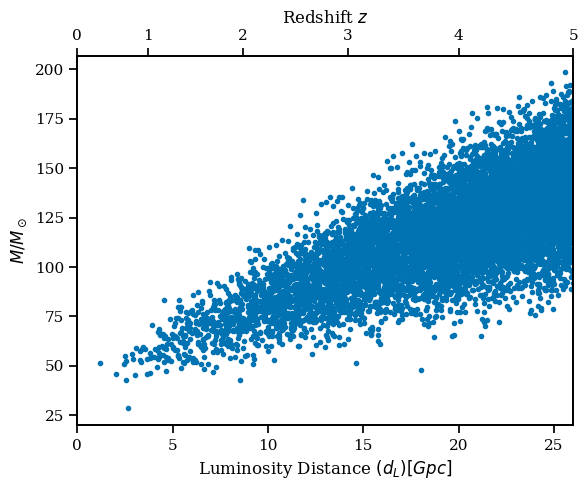

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.scatter(d_Ls/1000, m_det, marker='.')
ax1.set_xlabel(r"Luminosity Distance $(d_L) [Gpc]$")
ax1.set_ylabel(r"$M/M_\odot$")

tick_labels = np.linspace(0, 5, 6, dtype=int)
new_tick_locations = Planck18.luminosity_distance(tick_labels)
ax2.set_xlim(0, 5)
ax1.set_xlim(0, max(d_Ls/1000))
ax2.set_xticks(new_tick_locations.value)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel(r"Redshift $z$")
plt.show()

100%|██████████| 4/4 [00:31<00:00,  7.77s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

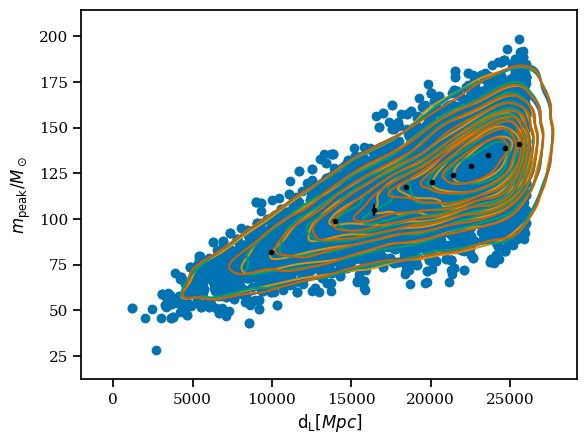

In [5]:
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(d_Ls)
dL_max = max(d_Ls)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(d_Ls, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = d_Ls[events]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.ylim(30, 50)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


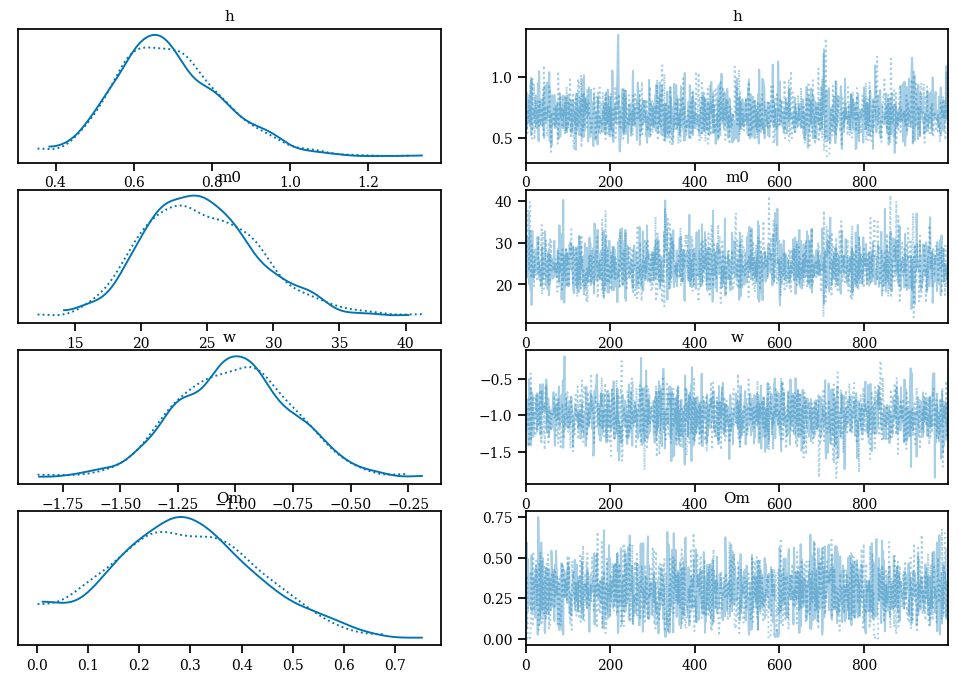

In [6]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = 5*np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

In [7]:
import matplotlib.colors as mcolors
cmap = list(mcolors.BASE_COLORS.keys())
print(len(cmap))

8


Text(0, 0.5, 'Probability Density [$\\mathrm{M_\\odot^{-1}}$]')

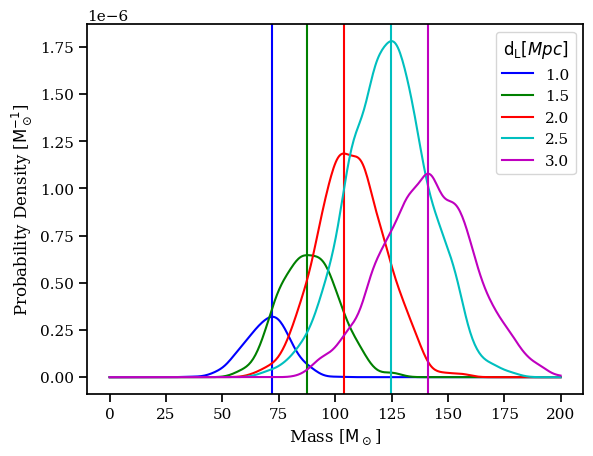

In [8]:
m_max = 200
zmn = 1
zmx = 3
z_ind = np.linspace(zmn, zmx, 5)

mass_indices = np.linspace(0, m_max, 400)

for j,d in enumerate(np.linspace(Planck18.luminosity_distance(zmn).value,
                                 Planck18.luminosity_distance(zmx).value, 5)):
    
    pdf = [kde.pdf([d, i]) for i in mass_indices]
    plt.plot(mass_indices, pdf,c=cmap[j], label=z_ind[j])
    plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])
    
plt.legend(title=r"$\mathrm{d_L}[Mpc]$")
plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
plt.ylabel(r"Probability Density [$\mathrm{M_\odot^{-1}}$]")

Redshifted peaks are all almost right on the money, which is nice

## Now make the split of events 50/50
This is what LIGO effectively sees due to selection effects, and it's a good test to see if the peakfinder ignores the peak of the power law

In [9]:
n_sam = int(1e3)
ms = generate_masses(n_sam, f=0.5)
ds = generate_dLs(n_sam)
z = dLs_to_zs(ds)

100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


(0.0, 30897.30614547989)

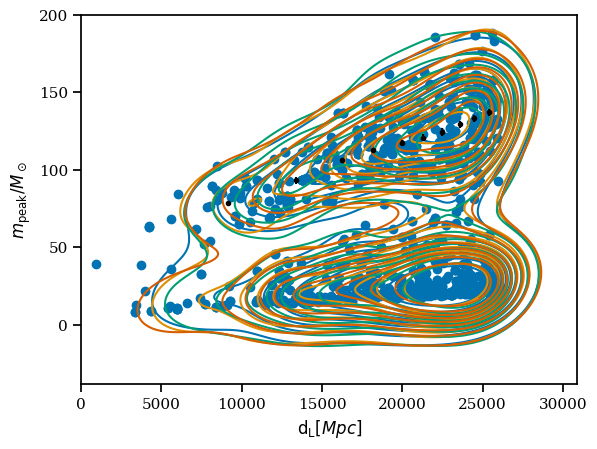

In [14]:
m_det = ms*(1+z)
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(ds)
dL_max = max(ds)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(ds, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = ds[events]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=200)
plt.xlim(left=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.


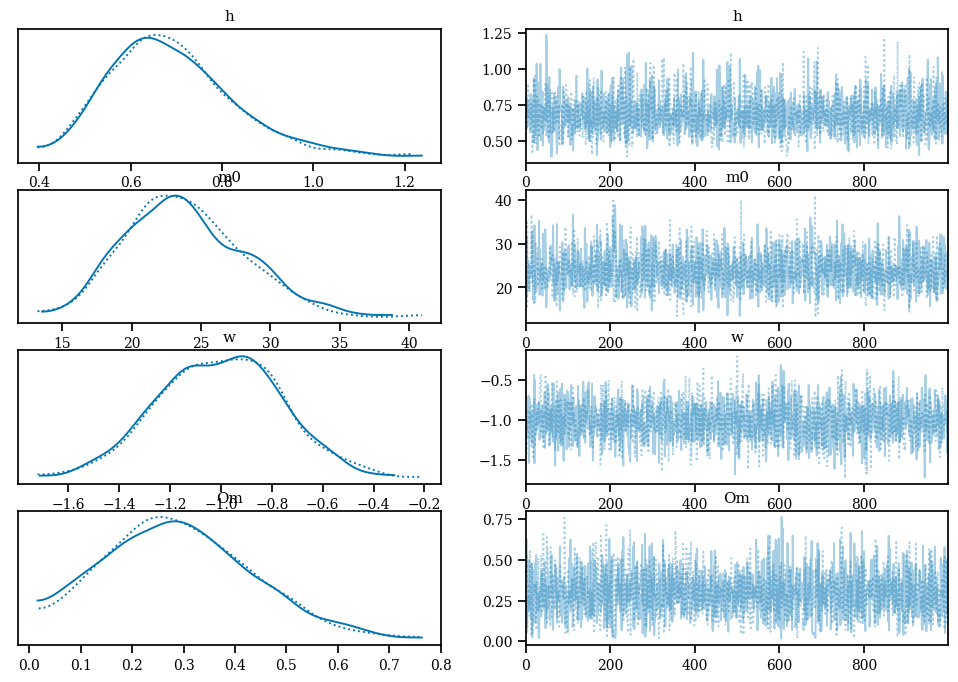

In [11]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = 5*np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

## Now, let's try dropping down the `zmin` to 0
Even the lower bound of $z=1$ is very far away, further than pretty much any LIGO event already seen. Therefore dropping `zmin` down to include the actually observed redshifts seems fairly important.

Making this work isn't straightforward though. The above method of just telling the peakfinder (`find_argmax_gridsearch`) to just ignore anything below $50M_\odot$ doesn't work anymore because now the peak we want drops well below that down to $35M_\odot$. This means we need a new way to cut out the power law peak. What we'll do is use Planck cosmology to mark a lower bound of $25M_\odot(1+z)$. This won't bias our final result though because the peak finder results should never include the boundary the Planck cutoff creates

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


(0.0, 31035.544579625082)

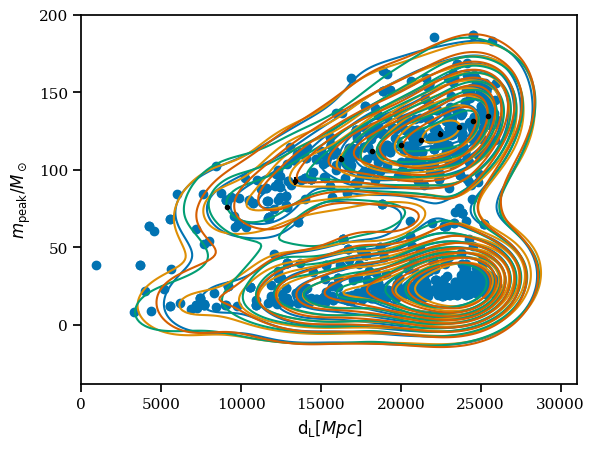

In [20]:
for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = ds[events]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)

    ### This loop is the only thing that's changed since the last run
    for i in range(n_dLs):
        redshifted_min = 25*(1+cosmo.z_at_value(Planck18.luminosity_distance, dL_cent[i]*u.Mpc))
        # print(redshifted_min)
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:], mmin=redshifted_min)
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
plt.ylim(top=200)
plt.xlim(left=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/Users/tanner/miniconda3/lib/python3.9/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


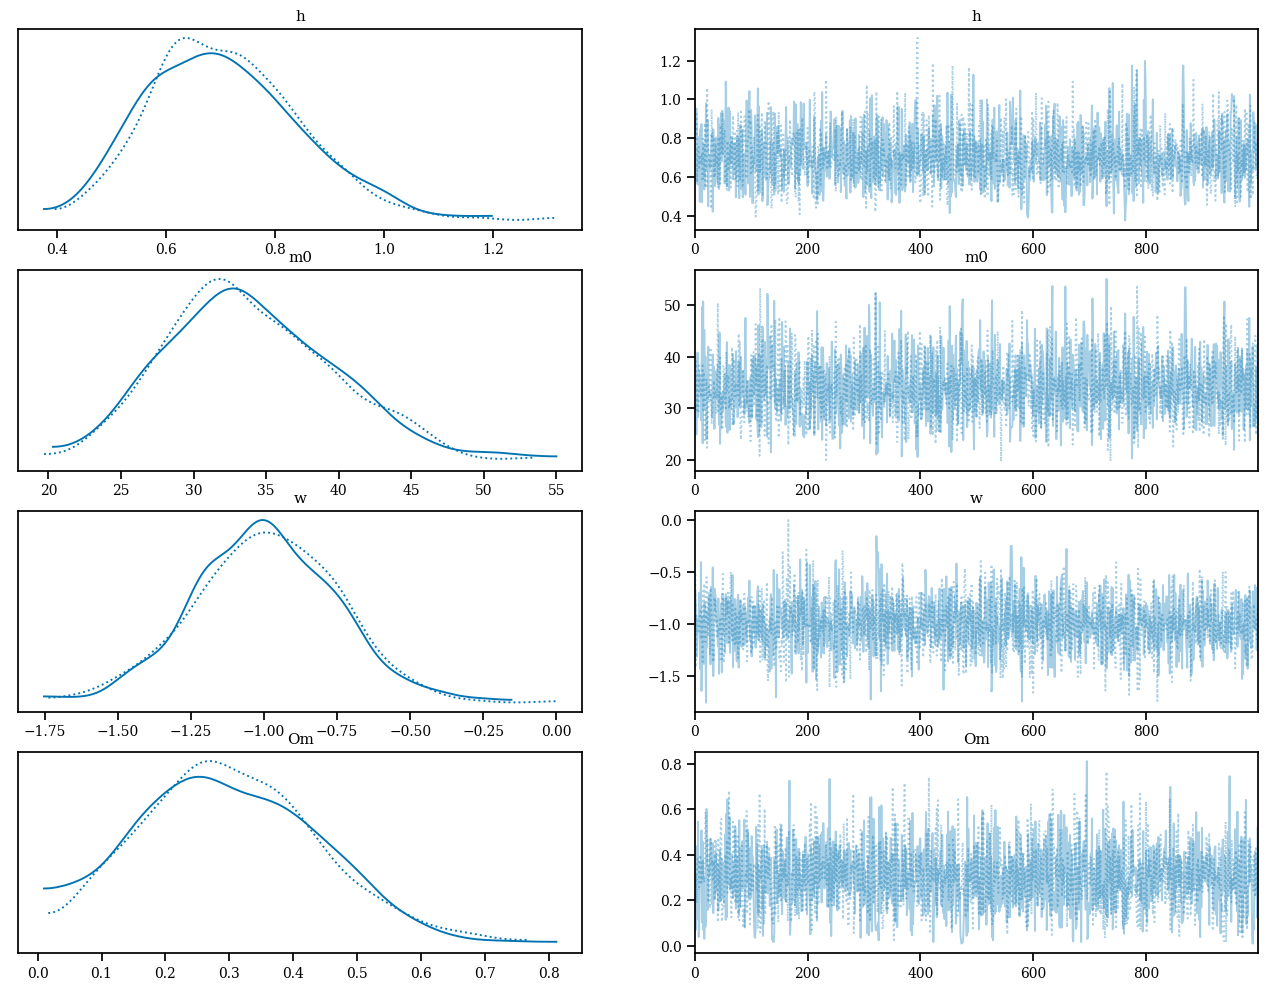

In [22]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = 5*np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=0, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'], figsize=(16, 12))
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace